In [1]:
# run stopwatch
from tools import Stopwatch
stopwatch = Stopwatch()
start = stopwatch.start()

### Load libraries, functions, palette, theme

In [383]:
%run _libraries.ipynb

In [384]:
%run _functions.ipynb

In [4]:
dir_current = '03-arima-month'

In [5]:
dir_save_files = 'files/'

In [6]:
dir_load_files = 'files/'

In [7]:
dir_save_img = 'docs/img/'

In [8]:
session_name = dir_current

# Section III. ARIMA

## Load Saved Section if exists

## Load Data

In [9]:
train = loadit('train_preprocessed', dir=dir_load_files)

In [10]:
valid = loadit('valid_preprocessed', dir=dir_load_files)

In [11]:
test = loadit('test_preprocessed', dir=dir_load_files)

In [12]:
target = 'target1'

In [13]:
features = ['is_Friday', 'is_Sunday', 'is_31', 'target1_previous_month']

## Naive Models

### First Naive Model

##### Predictions

In [14]:
y_pred_naive_first = valid[target].shift(1)[1:].copy()

In [15]:
y_true_naive_first = valid[target][1:].copy()

##### R-squared

In [16]:
round(r2_score(y_true_naive_first, y_pred_naive_first), 3)

0.99

##### MAE

In [17]:
math.ceil(mean_absolute_error(y_true_naive_first, y_pred_naive_first))

468

##### MAPE

In [18]:
round(mean_absolute_percentage_error(y_true_naive_first, y_pred_naive_first) * 100, 2)

1.33

##### RMSE

In [19]:
math.ceil(root_mean_squared_error(y_true_naive_first, y_pred_naive_first))

697

### Second Naive Model

##### Predictions

In [20]:
y_pred_naive_second = valid['target1_previous_month'].copy()

In [21]:
y_true_naive_second = valid[target].copy()

##### R-squared

In [22]:
round(r2_score(y_true_naive_second, y_pred_naive_second), 3)

0.746

##### MAE

In [23]:
math.ceil(mean_absolute_error(y_true_naive_second, y_pred_naive_second))

2763

##### MAPE

In [24]:
round(mean_absolute_percentage_error(y_true_naive_second, y_pred_naive_second) * 100, 2)

7.68

##### RMSE

In [25]:
math.ceil(root_mean_squared_error(y_true_naive_second, y_pred_naive_second))

3558

## Stationarity

p< 0.05: Enough evidence to say, that process is stationarity

In [26]:
# NULL: non-stationarity
sm.tsa.stattools.adfuller(train[target])

(-28.686047970170506,
 0.0,
 47,
 30480,
 {'1%': -3.4305645620343594,
  '5%': -2.8616348306743395,
  '10%': -2.566820475464527},
 460471.5647015386)

In [27]:
train['month'].unique()

array([1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [28]:
for i in train['month'].unique():
    print(sm.tsa.stattools.adfuller(train.loc[train['month']==i, target])[1])
    print(sm.tsa.stattools.adfuller(train.loc[train['month']==i, target])[1] < 0.05)

1.0644033759839667e-22
True
3.732657699349194e-20
True
7.432116387741869e-24
True
1.7428395333340719e-23
True
2.955844723407367e-22
True
4.44900636796093e-19
True
8.442519583711138e-20
True


In [29]:
for i in train['month'].unique():
    print(sm.tsa.stattools.adfuller(train.loc[train['month']==i, target].diff()[1:])[1])
    print(sm.tsa.stattools.adfuller(train.loc[train['month']==i, target].diff()[1:])[1] < 0.05)

4.97351764764749e-26
True
4.483001520404638e-24
True
6.141089115772981e-28
True
3.702018465634753e-28
True
1.1368337132320429e-27
True
5.506358370607743e-23
True
1.2150033480795901e-26
True


## Autocorrelation

### Datasets

Train: July data;  
Validation: August data.

In [30]:
y = train.loc['2017-03', target].copy()

In [31]:
y

2017-03-01 00:00:00    29069.61702
2017-03-01 00:10:00    28579.40426
2017-03-01 00:20:00    27844.08511
2017-03-01 00:30:00    27237.44681
2017-03-01 00:40:00    26882.04255
                          ...     
2017-03-31 23:10:00    33052.59574
2017-03-31 23:20:00    32292.76596
2017-03-31 23:30:00    31042.72340
2017-03-31 23:40:00    30025.53191
2017-03-31 23:50:00    29339.23404
Freq: 10min, Name: target1, Length: 4464, dtype: float64

#### ACF - 40 period

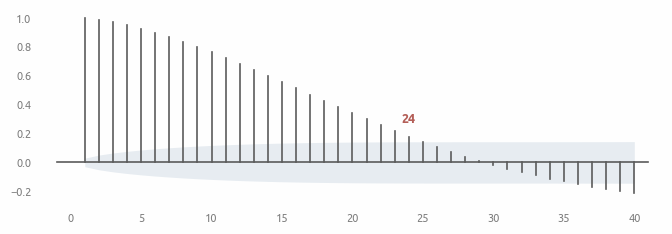

In [32]:
fig = plt.figure()
plot_acf(data=y, lags=40)

In [33]:
ts_acf_last_significant_index(y)

24

#### ACF - 300 period

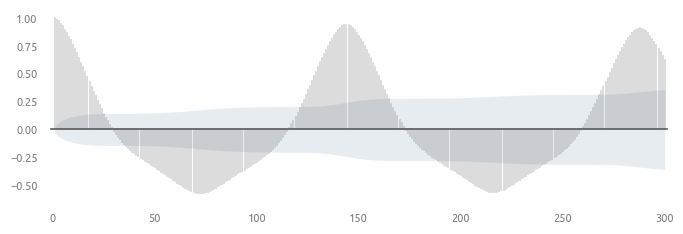

Images 'ACF_300.png' and 'ACF_300.svg' successfully saved into 'docs/img/' directory


In [34]:
fig = plt.figure()
plot_acf(data=y, lags=300, transparency_lines=0.25, show_last_significant=False)
plt.show()
savefig('ACF_300', dir_save_img)

#### PACF - 36 period

In [35]:
pacf = ts_acf_calculate(y, lags=36, partial=True)

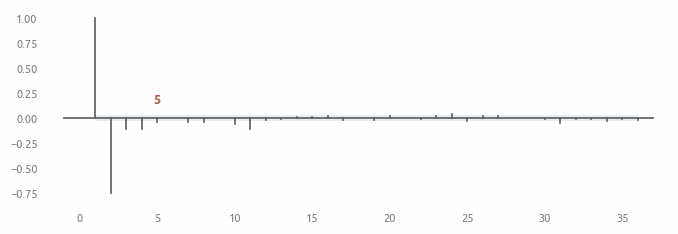

Images 'PACF.png' and 'PACF.svg' successfully saved into 'docs/img/' directory


In [36]:
fig = plt.figure()
plot_acf(data=y, lags=36, last_significant_delta=0.175, partial=True)
plt.show()
savefig('PACF', dir_save_img)

## Cross-validation Schema

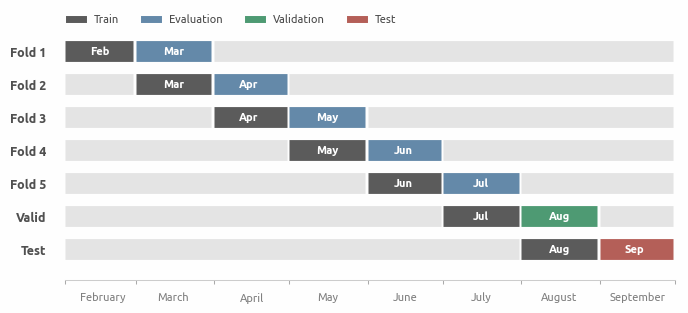

Images 'cv_schema.png' and 'cv_schema.svg' successfully saved into 'docs/img/' directory


In [37]:
train_start = dt.datetime(2017,2,1)
back_start = dt.datetime(2017,2,1)
forward_finish = dt.datetime(2017,9,30)
lw=15
k_ = 0

fig = plt.figure(figsize=(8, 3))
ax=ax_current()

for i in arange(7):
    back_finish = train_start - dt.timedelta(days=1)
    ev_start = dt.datetime(2017, train_start.month+1, 1)
    forward_start = dt.datetime(2017, train_start.month+2, 1)
    train_finish = \
        dt.datetime(2017, train_start.month+1, 1) - dt.timedelta(days=1)
    ev_finish = \
        dt.datetime(2017, train_start.month+2, 1) - dt.timedelta(days=1)
    
    range_back = pd.date_range(back_start, back_finish, freq='d')
    range_train = pd.date_range(train_start, train_finish, freq='d')
    range_ev = pd.date_range(ev_start, ev_finish, freq='d')
    range_forward = pd.date_range(forward_start, forward_finish, freq='d')

    len_train = (train_finish - train_start).days
    len_ev = (ev_finish - ev_start).days

    color_back = color_forward = alpha_color(palette[-1], 0.4)
    color_ev = alpha_color(palette[2], 1)
    
    if i == 5:
        color_ev = palette[3]
    if i == 6:
        color_ev = palette[1]

    ax.plot(
        range_back,
        [7-i]*len(range_back),
        lw=lw,
        solid_capstyle='butt',
        color=color_back)

    ax.plot(
        range_train,
        [7-i]*len(range_train),
        lw=lw,
        solid_capstyle='butt',
        color=palette[0])

    ax.plot(
        range_ev,
        [7-i]*len(range_ev),
        lw=lw,
        solid_capstyle='butt',
        color=color_ev)

    ax.plot(
        range_forward,
        [7-i]*len(range_forward),
        lw=lw,
        solid_capstyle='butt',
        color=color_forward)
    
    ax.annotate(
        train_start.strftime("%B")[:3],
        xy=(dt.datetime(2017, train_start.month,
                        int(round(len_train/2))+1), 7-i-0.1),
        ha='center',
        color='white',
        weight='bold',
        size=8)

    ax.annotate(
        ev_start.strftime("%B")[:3],
        xy=(dt.datetime(2017, ev_start.month,
                        int(round(len_ev/2))+1), 7-i-0.1),
        ha='center',
        color='white',
        weight='bold',
        size=8)
    
    train_start = dt.datetime(2017, train_start.month+1, 1)

ax.legend(
    **legend_create_handles(
        n=4, kind='rect',
        labels=['Train', 'Evaluation', 'Validation', 'Test'],
        colors=[palette[0], alpha_color(palette[2], 1),
                palette[3], palette[1]], alpha=1),
    **legend_inline())

axis_rstyle(
    y_axis_hide=True, x_ticks_hide=True, offset_left=0)

ax_sec = ax.secondary_xaxis('bottom')
ax_sec.set_xticks(ax.get_xticks())
ax_sec.spines['bottom'].set_visible(False)
ax_sec.spines['bottom'].set_position(('outward', 13))
ax_sec.tick_params(axis='x', labelbottom=False, size=3)

ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%B'))
ax.xaxis.set_major_locator(mpl.dates.DayLocator(bymonthday=16))

ax.set_yticks(
    ticks=arange(1, 8),
    labels=[
        'Test', 'Valid', 'Fold 5', 'Fold 4',
        'Fold 3', 'Fold 2', 'Fold 1'],
    fontsize=9,
    weight='bold',
    color=palette[0]
)
ax.tick_params(axis='y', colors='#505050')

ax.set_ylim(0.5, 7.5)

plt.show()
savefig('cv_schema', dir_save_img)

In [38]:
len(train.loc['2017-03-01':]['month'].unique())

5

In [39]:
cv_indexes_train, cv_indexes_eval = cv_split_indexes(
    data=train['target1'], start='2017-03-01', train_size=1,
    test_size=1, size_unit='months', n_splits=5, freq='10min')

In [40]:
cv_indexes_train[0]

DatetimeIndex(['2017-02-01 00:00:00', '2017-02-01 00:10:00',
               '2017-02-01 00:20:00', '2017-02-01 00:30:00',
               '2017-02-01 00:40:00', '2017-02-01 00:50:00',
               '2017-02-01 01:00:00', '2017-02-01 01:10:00',
               '2017-02-01 01:20:00', '2017-02-01 01:30:00',
               ...
               '2017-02-28 22:20:00', '2017-02-28 22:30:00',
               '2017-02-28 22:40:00', '2017-02-28 22:50:00',
               '2017-02-28 23:00:00', '2017-02-28 23:10:00',
               '2017-02-28 23:20:00', '2017-02-28 23:30:00',
               '2017-02-28 23:40:00', '2017-02-28 23:50:00'],
              dtype='datetime64[ns]', length=4032, freq='10min')

In [41]:
cv_indexes_eval[0]

DatetimeIndex(['2017-03-01 00:00:00', '2017-03-01 00:10:00',
               '2017-03-01 00:20:00', '2017-03-01 00:30:00',
               '2017-03-01 00:40:00', '2017-03-01 00:50:00',
               '2017-03-01 01:00:00', '2017-03-01 01:10:00',
               '2017-03-01 01:20:00', '2017-03-01 01:30:00',
               ...
               '2017-03-31 22:20:00', '2017-03-31 22:30:00',
               '2017-03-31 22:40:00', '2017-03-31 22:50:00',
               '2017-03-31 23:00:00', '2017-03-31 23:10:00',
               '2017-03-31 23:20:00', '2017-03-31 23:30:00',
               '2017-03-31 23:40:00', '2017-03-31 23:50:00'],
              dtype='datetime64[ns]', length=4464, freq='10min')

In [42]:
cv_indexes_train[-1]

DatetimeIndex(['2017-06-01 00:00:00', '2017-06-01 00:10:00',
               '2017-06-01 00:20:00', '2017-06-01 00:30:00',
               '2017-06-01 00:40:00', '2017-06-01 00:50:00',
               '2017-06-01 01:00:00', '2017-06-01 01:10:00',
               '2017-06-01 01:20:00', '2017-06-01 01:30:00',
               ...
               '2017-06-30 22:20:00', '2017-06-30 22:30:00',
               '2017-06-30 22:40:00', '2017-06-30 22:50:00',
               '2017-06-30 23:00:00', '2017-06-30 23:10:00',
               '2017-06-30 23:20:00', '2017-06-30 23:30:00',
               '2017-06-30 23:40:00', '2017-06-30 23:50:00'],
              dtype='datetime64[ns]', length=4320, freq='10min')

In [43]:
cv_indexes_eval[-1]

DatetimeIndex(['2017-07-01 00:00:00', '2017-07-01 00:10:00',
               '2017-07-01 00:20:00', '2017-07-01 00:30:00',
               '2017-07-01 00:40:00', '2017-07-01 00:50:00',
               '2017-07-01 01:00:00', '2017-07-01 01:10:00',
               '2017-07-01 01:20:00', '2017-07-01 01:30:00',
               ...
               '2017-07-31 22:20:00', '2017-07-31 22:30:00',
               '2017-07-31 22:40:00', '2017-07-31 22:50:00',
               '2017-07-31 23:00:00', '2017-07-31 23:10:00',
               '2017-07-31 23:20:00', '2017-07-31 23:30:00',
               '2017-07-31 23:40:00', '2017-07-31 23:50:00'],
              dtype='datetime64[ns]', length=4464, freq='10min')

## Choose AR, I, MA parameters

### Cross-validation 0: AR, I, MA parameters

5-Fold CV:

- All combinations from 1 to 6 for AR and MA parameters  
- 0 and 1 for I parameter

In [44]:
%%time
cv0_results_dict = {}
# for all combinations of (1,1), (1,2), (1,3) ... (6,6)
for i in [0, 1]:
    for arma in itertools.product(arange(1,6,True), repeat=2):
        
        order = (arma[0], i, arma[1])
        model_name = f'ARIMA {order}'
        rmse0_list = []
        
        for idx_train, idx_eval in zip(cv_indexes_train, cv_indexes_eval):
            
            rmse0_local = cv_arima_evaluation(
                data_train=train.loc[idx_train, target],
                data_eval=train.loc[idx_eval, target],
                order=order,
                metric=root_mean_squared_error,
                exec_time=False,
                clear_output_include=False)
            
            rmse0_list.append(rmse0_local)
            
        cv0_results_dict[model_name] = rmse0_list
        print(f'Evaluation of model ARIMA ({order}) is finished')
        
clear_output()

CPU times: user 1h 7min 17s, sys: 7min 11s, total: 1h 14min 28s
Wall time: 38min 53s


In [45]:
cv0_results_df = pd.DataFrame(cv0_results_dict)

In [46]:
cv0_results_df.mean().sort_values().head(40)

ARIMA (4, 1, 5)     7303.664716
ARIMA (2, 1, 1)     7519.199170
ARIMA (4, 1, 6)     7570.347830
ARIMA (5, 1, 6)     7707.666256
ARIMA (5, 1, 5)     7751.246581
ARIMA (6, 1, 5)     7798.087172
ARIMA (1, 1, 1)     7843.911236
ARIMA (6, 1, 6)     8024.138951
ARIMA (4, 1, 2)     8102.384545
ARIMA (3, 1, 3)     8118.864223
ARIMA (6, 1, 3)     8119.212355
ARIMA (3, 1, 2)     8123.920693
ARIMA (3, 1, 1)     8165.402681
ARIMA (1, 1, 4)     8168.211294
ARIMA (5, 1, 1)     8181.729952
ARIMA (5, 1, 4)     8198.211110
ARIMA (6, 1, 2)     8211.205565
ARIMA (4, 1, 1)     8211.803555
ARIMA (2, 1, 4)     8221.469344
ARIMA (5, 1, 2)     8234.295762
ARIMA (2, 1, 3)     8235.210637
ARIMA (6, 1, 1)     8241.793791
ARIMA (1, 1, 3)     8266.221352
ARIMA (1, 1, 5)     8280.978882
ARIMA (3, 1, 4)     8295.432572
ARIMA (4, 1, 3)     8310.366350
ARIMA (2, 1, 5)     8332.085230
ARIMA (2, 1, 6)     8338.724990
ARIMA (1, 1, 6)     8353.053542
ARIMA (2, 1, 2)     8356.150081
ARIMA (6, 1, 4)     8380.419346
ARIMA (5

In [47]:
arima415 = SARIMAX(
    endog=y, exog=None,
    order=(4,1,5),
    seasonal_order=(0, 0, 0, 0)
).fit(maxiter=1000, disp=False)

In [48]:
print(arima415.summary())

                               SARIMAX Results                                
Dep. Variable:                target1   No. Observations:                 4464
Model:               SARIMAX(4, 1, 5)   Log Likelihood              -33588.460
Date:                Sun, 21 Apr 2024   AIC                          67196.919
Time:                        14:19:50   BIC                          67260.955
Sample:                    03-01-2017   HQIC                         67219.492
                         - 03-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2747      1.681      0.758      0.448      -2.021       4.570
ar.L2         -1.0380      0.850     -1.221      0.222      -2.704       0.628
ar.L3          1.2676      1.114      1.138      0.2

In [49]:
arima211 = SARIMAX(
    endog=y, exog=None,
    order=(2,1,1),
    seasonal_order=(0, 0, 0, 0)
).fit(maxiter=1000, disp=False)

In [50]:
print(arima211.summary())

                               SARIMAX Results                                
Dep. Variable:                target1   No. Observations:                 4464
Model:               SARIMAX(2, 1, 1)   Log Likelihood              -33599.766
Date:                Sun, 21 Apr 2024   AIC                          67207.533
Time:                        14:19:51   BIC                          67233.147
Sample:                    03-01-2017   HQIC                         67216.562
                         - 03-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0840      0.062     17.546      0.000       0.963       1.205
ar.L2         -0.2069      0.044     -4.701      0.000      -0.293      -0.121
ma.L1         -0.4988      0.061     -8.200      0.0

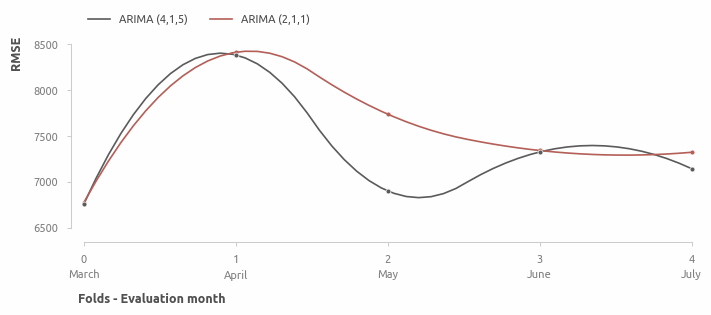

In [51]:
plt.scatter(
    x=cv0_results_df['ARIMA (4, 1, 5)'].index,
    y=cv0_results_df['ARIMA (4, 1, 5)'],
    s=50,
    zorder=10,
    lw=0.5)
plt.plot(
    smoothed(cv0_results_df['ARIMA (4, 1, 5)'], n=50, k=2), label='ARIMA (4,1,5)')
plt.scatter(
    x=cv0_results_df['ARIMA (2, 1, 1)'].index,
    y=cv0_results_df['ARIMA (2, 1, 1)'],
    s=50,
    lw=0.5)
plt.plot(
    smoothed(cv0_results_df['ARIMA (2, 1, 1)'], n=50, k=2), label='ARIMA (2,1,1)')

axis_rstyle(xticks=[0,4,1], yticks=[6500, 8500, 500], ylim=[6500, 8600])
plt.legend(**legend_inline())
plt.xlabel('Folds - Evaluation month', labelpad=20)
plt.ylabel('RMSE')

ax_sec = axis_secondary(ax=ax_current(), pad=30)
ax_sec.set_xticks(arange(5), months_list[2:7])

plt.show()

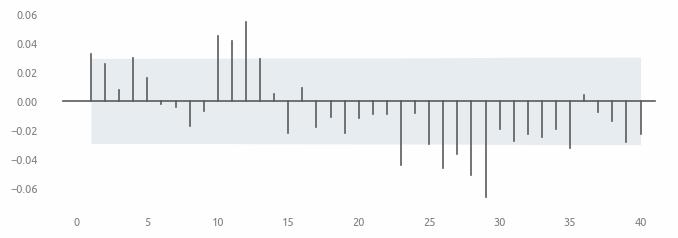

In [52]:
# should plot resid[d:], where d is d-order of ARIMA model
plot_acf(data=arima415.resid[1:])

## Managing seasonality and adding features

### Stationarity of covariates

In [53]:
# NULL: non-stationarity
sm.tsa.stattools.adfuller(train.loc['2017-07-01':, 'target1_previous_month'])

(-10.780262352765597,
 2.264652307844371e-19,
 25,
 4438,
 {'1%': -3.4318243322143682,
  '5%': -2.8621914772569323,
  '10%': -2.567116785250736},
 67265.01178270859)

### Fourier transform for seasonal patterns

In [54]:
y_values = train.loc['2017-05', target].values

In [55]:
y_values_trend = scipy.signal.savgol_filter(y_values, 25, 1)

In [56]:
y_values_detrended = y_values - y_values_trend

In [57]:
fft_x = np.fft.fftfreq(len(y_values_detrended))
fft_x = fft_x[:len(fft_x)//2]

In [58]:
fft_y = np.fft.fft(y_values_detrended)
fft_y = np.abs(fft_y[:len(fft_y)//2])

In [59]:
fft_y_peaks_indices = get_peaks_indicies(fft_y, boundary=500000)

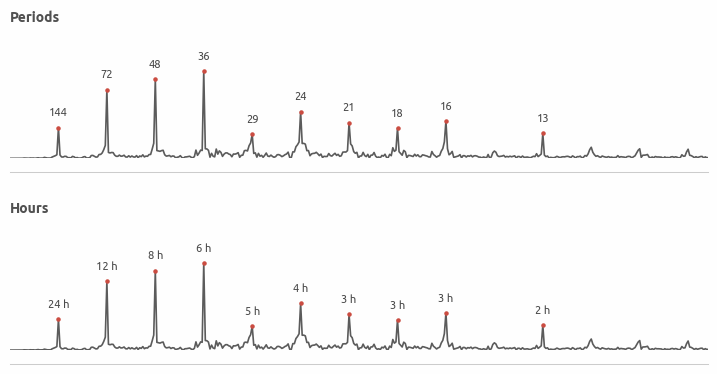

Images 'fourier_transform.png' and 'fourier_transform.svg' successfully saved into 'docs/img/' directory


In [60]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4))

plt.subplot(2, 1, 1)
plt.plot(fft_x, fft_y)
for idx in fft_y_peaks_indices:
    x_, y_ = fft_x[idx], fft_y[idx]
    text = f'{round(1/x_)}'
    plt.annotate(text, (x_, y_+300000), ha='center', size=8)
    plt.scatter(
        fft_x[idx], fft_y[idx],
        color=saturate_color(palette[1], 1.5), marker='.', s=20, zorder=10)

plt.title('Periods')
plt.xlim(0, 0.1)
plt.ylim(0, 3000000)
axis_rstyle(y_axis_hide=True, y_ticklabels_hide=True, x_ticklabels_hide=True, x_ticks_hide=True)

plt.subplot(2, 1, 2)
plt.plot(fft_x, fft_y)
for idx in fft_y_peaks_indices:
    x_, y_ = fft_x[idx], fft_y[idx]
    text = f'{round(1/x_/6)} h'
    plt.annotate(text, (x_, y_+300000), ha='center', size=8)
    plt.scatter(
        fft_x[idx], fft_y[idx],
        color=saturate_color(palette[1], 1.5), marker='.', s=20, zorder=10)

plt.title('Hours')
plt.xlim(0, 0.1)
plt.ylim(0, 3000000)
axis_rstyle(y_axis_hide=True, y_ticklabels_hide=True, x_ticklabels_hide=True, x_ticks_hide=True)

plt.subplots_adjust(hspace=0.65)
plt.show()

savefig('fourier_transform', dir_save_img)

### Cross-validation 1: Fourier period and order

5-Fold CV:

- Models: ARIMA (4,1,5), ARIMA (2,1,1)
- Periods: all combinations from 144 to (144, 72, 48, 36)
- Orders: 2 to 4 (equal orders, without conbinations)

Explore optimal Fourier period and order

In [61]:
cv_indexes_train[0]

DatetimeIndex(['2017-02-01 00:00:00', '2017-02-01 00:10:00',
               '2017-02-01 00:20:00', '2017-02-01 00:30:00',
               '2017-02-01 00:40:00', '2017-02-01 00:50:00',
               '2017-02-01 01:00:00', '2017-02-01 01:10:00',
               '2017-02-01 01:20:00', '2017-02-01 01:30:00',
               ...
               '2017-02-28 22:20:00', '2017-02-28 22:30:00',
               '2017-02-28 22:40:00', '2017-02-28 22:50:00',
               '2017-02-28 23:00:00', '2017-02-28 23:10:00',
               '2017-02-28 23:20:00', '2017-02-28 23:30:00',
               '2017-02-28 23:40:00', '2017-02-28 23:50:00'],
              dtype='datetime64[ns]', length=4032, freq='10min')

In [62]:
cv_indexes_eval[0]

DatetimeIndex(['2017-03-01 00:00:00', '2017-03-01 00:10:00',
               '2017-03-01 00:20:00', '2017-03-01 00:30:00',
               '2017-03-01 00:40:00', '2017-03-01 00:50:00',
               '2017-03-01 01:00:00', '2017-03-01 01:10:00',
               '2017-03-01 01:20:00', '2017-03-01 01:30:00',
               ...
               '2017-03-31 22:20:00', '2017-03-31 22:30:00',
               '2017-03-31 22:40:00', '2017-03-31 22:50:00',
               '2017-03-31 23:00:00', '2017-03-31 23:10:00',
               '2017-03-31 23:20:00', '2017-03-31 23:30:00',
               '2017-03-31 23:40:00', '2017-03-31 23:50:00'],
              dtype='datetime64[ns]', length=4464, freq='10min')

In [63]:
cv_indexes_train[-1]

DatetimeIndex(['2017-06-01 00:00:00', '2017-06-01 00:10:00',
               '2017-06-01 00:20:00', '2017-06-01 00:30:00',
               '2017-06-01 00:40:00', '2017-06-01 00:50:00',
               '2017-06-01 01:00:00', '2017-06-01 01:10:00',
               '2017-06-01 01:20:00', '2017-06-01 01:30:00',
               ...
               '2017-06-30 22:20:00', '2017-06-30 22:30:00',
               '2017-06-30 22:40:00', '2017-06-30 22:50:00',
               '2017-06-30 23:00:00', '2017-06-30 23:10:00',
               '2017-06-30 23:20:00', '2017-06-30 23:30:00',
               '2017-06-30 23:40:00', '2017-06-30 23:50:00'],
              dtype='datetime64[ns]', length=4320, freq='10min')

In [64]:
cv_indexes_eval[-1]

DatetimeIndex(['2017-07-01 00:00:00', '2017-07-01 00:10:00',
               '2017-07-01 00:20:00', '2017-07-01 00:30:00',
               '2017-07-01 00:40:00', '2017-07-01 00:50:00',
               '2017-07-01 01:00:00', '2017-07-01 01:10:00',
               '2017-07-01 01:20:00', '2017-07-01 01:30:00',
               ...
               '2017-07-31 22:20:00', '2017-07-31 22:30:00',
               '2017-07-31 22:40:00', '2017-07-31 22:50:00',
               '2017-07-31 23:00:00', '2017-07-31 23:10:00',
               '2017-07-31 23:20:00', '2017-07-31 23:30:00',
               '2017-07-31 23:40:00', '2017-07-31 23:50:00'],
              dtype='datetime64[ns]', length=4464, freq='10min')

In [65]:
fourier_periods = [
    [144],
    [144, 72],
    [144, 72, 48],
    [144, 72, 48, 36]
]

In [66]:
fourier_orders = [2, 3, 4]

In [67]:
model_orders = [
    (2, 1, 1),
    (4, 1, 5)
]

In [68]:
%%time

cv1_results_dict = {}
for order in model_orders:
    for f_period in fourier_periods:
        for fourier_order in fourier_orders:
            f_order = [fourier_order] * len(f_period)
            model_name = f'ARIMA {order} {tuple(f_period)} {tuple(f_order)}'
            rmse1_list = []
            
            for idx_train, idx_eval in zip(cv_indexes_train, cv_indexes_eval):

                train_data = train.loc[idx_train, target]
                eval_data = train.loc[idx_eval, target]

                train_w_exogs, eval_w_exogs = \
                    datasets_w_fourier(
                        fourier_period=f_period,
                        fourier_order=f_order,
                        train_data=train_data,
                        eval_data=eval_data,
                        train_exog=train.loc[idx_train, features],
                        eval_exog=train.loc[idx_eval, features])      

                rmse1_local = cv_arima_evaluation(
                    data_train=train_data,
                    data_eval=eval_data,
                    order=order,
                    exog_train=train_w_exogs,
                    exog_eval=eval_w_exogs,
                    metric=root_mean_squared_error,
                    exec_time=False,
                    clear_output_include=False)

                rmse1_list.append(rmse1_local)

            cv1_results_dict[model_name] = rmse1_list
            print(f'Evaluation of model {model_name} is finished')

clear_output()

CPU times: user 3h 23min 30s, sys: 37min 34s, total: 4h 1min 4s
Wall time: 1h 25min 32s


In [69]:
cv1_results_df = pd.DataFrame(cv1_results_dict)

In [70]:
cv1_results_df

,"ARIMA (2, 1, 1) (144,) (2,)","ARIMA (2, 1, 1) (144,) (3,)","ARIMA (2, 1, 1) (144,) (4,)","ARIMA (2, 1, 1) (144, 72) (2, 2)","ARIMA (2, 1, 1) (144, 72) (3, 3)","ARIMA (2, 1, 1) (144, 72) (4, 4)","ARIMA (2, 1, 1) (144, 72, 48) (2, 2, 2)","ARIMA (2, 1, 1) (144, 72, 48) (3, 3, 3)","ARIMA (2, 1, 1) (144, 72, 48) (4, 4, 4)","ARIMA (2, 1, 1) (144, 72, 48, 36) (2, 2, 2, 2)",...,"ARIMA (4, 1, 5) (144,) (4,)","ARIMA (4, 1, 5) (144, 72) (2, 2)","ARIMA (4, 1, 5) (144, 72) (3, 3)","ARIMA (4, 1, 5) (144, 72) (4, 4)","ARIMA (4, 1, 5) (144, 72, 48) (2, 2, 2)","ARIMA (4, 1, 5) (144, 72, 48) (3, 3, 3)","ARIMA (4, 1, 5) (144, 72, 48) (4, 4, 4)","ARIMA (4, 1, 5) (144, 72, 48, 36) (2, 2, 2, 2)","ARIMA (4, 1, 5) (144, 72, 48, 36) (3, 3, 3, 3)","ARIMA (4, 1, 5) (144, 72, 48, 36) (4, 4, 4, 4)"
0,4176.918575,1817.035010,1826.037357,4162.986029,1876.286358,1924.621139,1876.284607,1855.921664,1931.100256,1924.602562,...,1870.328233,4213.261630,1896.888398,1957.870881,1903.135835,1913.802095,1926.762063,1957.885326,1929.778687,1935.495340
1,4254.743914,2545.759263,1992.133181,3771.786591,2025.458528,1988.731085,2025.459911,2018.516579,1981.578932,1988.728625,...,2128.610178,2660.552437,2139.368140,2095.024460,2139.380041,2141.638688,1989.425842,2094.979521,1989.425405,2003.245692
2,4776.777352,3409.871276,2742.756733,3939.394613,2884.106786,2726.233169,2884.106786,2794.979486,2676.781127,2726.233170,...,2684.060932,4073.094246,2944.388971,2953.631391,2944.389215,2688.719061,2919.061875,2953.631067,2919.060702,2956.736273
3,4616.359183,4642.470249,4658.809261,4930.712563,4698.025080,4734.542189,4698.084804,4722.398160,4759.396635,4734.543977,...,4660.732979,4535.828748,4698.621966,4735.712295,4699.228311,4724.682890,4760.651859,4735.548684,4762.431028,4763.528557
4,9273.729030,8427.225561,6019.664304,6261.578982,6063.449183,6052.972046,6063.449235,6056.539454,6038.589031,6052.977901,...,6001.224409,6251.847948,6025.424724,6028.473222,6022.760043,6029.169054,6012.129428,6023.234976,6024.416903,6006.542797


In [71]:
cv1_results_mean = cv1_results_df.mean(axis=0)

In [72]:
cv1_results_mean_std = cv1_results_df.std()

In [73]:
cv1_results_mean.sort_values()

ARIMA (2, 1, 1) (144,) (4,)                       3447.880167
ARIMA (4, 1, 5) (144,) (4,)                       3468.991346
ARIMA (2, 1, 1) (144, 72, 48, 36) (3, 3, 3, 3)    3477.486594
ARIMA (2, 1, 1) (144, 72, 48) (4, 4, 4)           3477.489196
ARIMA (2, 1, 1) (144, 72, 48, 36) (4, 4, 4, 4)    3481.697761
ARIMA (2, 1, 1) (144, 72, 48, 36) (2, 2, 2, 2)    3485.417247
ARIMA (2, 1, 1) (144, 72) (4, 4)                  3485.419926
ARIMA (2, 1, 1) (144, 72, 48) (3, 3, 3)           3489.671068
ARIMA (4, 1, 5) (144, 72, 48) (3, 3, 3)           3499.602358
ARIMA (2, 1, 1) (144, 72) (3, 3)                  3509.465187
ARIMA (2, 1, 1) (144, 72, 48) (2, 2, 2)           3509.477069
ARIMA (4, 1, 5) (144, 72, 48) (4, 4, 4)           3521.606213
ARIMA (4, 1, 5) (144, 72, 48, 36) (3, 3, 3, 3)    3525.022545
ARIMA (4, 1, 5) (144, 72, 48, 36) (4, 4, 4, 4)    3533.109732
ARIMA (4, 1, 5) (144, 72) (3, 3)                  3540.938440
ARIMA (4, 1, 5) (144, 72, 48) (2, 2, 2)           3541.778689
ARIMA (4

In [74]:
cv1_results_plot_labels = [i[16:] for i in cv1_results_mean.index]

In [75]:
cv1_results_best_model = cv1_results_mean.sort_values().index[0]
cv1_results_best_model_index = \
    list(cv1_results_mean.index).index(cv1_results_best_model)

In [76]:
cv1_results_second_best_model = cv1_results_mean.sort_values().index[1]
cv1_results_second_best_model_index = \
    list(cv1_results_mean.index).index(cv1_results_second_best_model)

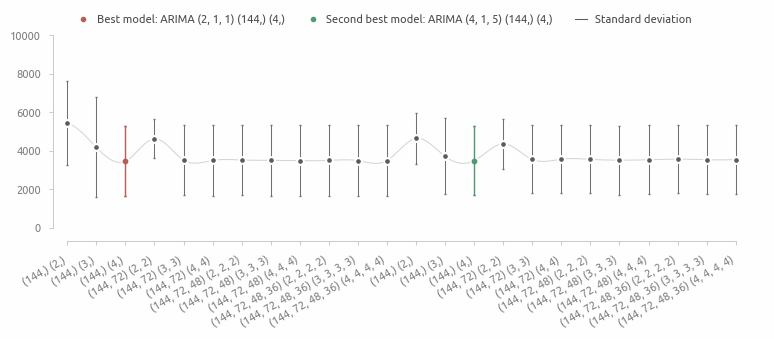

In [77]:
plt.figure(figsize=(9, 2.5))

plt.plot(smoothed(cv1_results_mean.values), lw=0.75, alpha=0.25)
plt.scatter(
    x=arange(len(cv1_results_mean)),
    y=cv1_results_mean, s=95, lw=1.5, clip_on=False, zorder=10)

plt.scatter(
    cv1_results_best_model_index,
    cv1_results_mean[cv1_results_best_model],
    s=40, color=palette[1],
    label=f'Best model: {cv1_results_best_model}',
    clip_on=False, zorder=100)

plt.scatter(
    cv1_results_second_best_model_index,
    cv1_results_mean[cv1_results_second_best_model],
    s=40, color=palette[3],
    label=f'Second best model: {cv1_results_second_best_model}',
    clip_on=False, zorder=100)

plt.errorbar(
    x=arange(len(cv1_results_mean)),
    y=cv1_results_mean,
    yerr=cv1_results_mean_std,
    c=palette[-1],
    linestyle='none',
    elinewidth=0.75,
    capsize=1,
    ecolor=palette[-3],
    # alpha=0.75,
    clip_on=False,
    zorder=1,
    label='Standard deviation')

plt.errorbar(
    x=cv1_results_best_model_index,
    y=cv1_results_mean.loc[cv1_results_best_model],
    yerr=cv1_results_mean_std.loc[cv1_results_best_model],
    c=palette[1],
    linestyle='none',
    elinewidth=1,
    capsize=1,
    ecolor=palette[1],
    clip_on=False,
    # alpha=0.75,
    zorder=12)

plt.errorbar(
    x=cv1_results_second_best_model_index,
    y=cv1_results_mean.loc[cv1_results_second_best_model],
    yerr=cv1_results_mean_std.loc[cv1_results_second_best_model],
    c=palette[1],
    linestyle='none',
    elinewidth=1,
    capsize=1,
    ecolor=palette[3],
    clip_on=False,
    # alpha=0.75,
    zorder=12)

axis_rstyle(
    offset_left=10,
    ylim=[0, 10000],
    yticks=[0, 10000, 2000],
    xlim=[0, len(cv1_results_mean)],
    x_spine_lim=[0, len(cv1_results_mean)-1])

plt.xticks(
    ticks=arange(len(cv1_results_mean)),
    labels=cv1_results_plot_labels, rotation=30, ha='right')

plt.legend(
    **legend_inline(),
    **legend_create_handles(
        3, kind=['point', 'point', 'line'],
        colors=[palette[1], palette[3], palette[0]], linewidth=0.75))

plt.show()

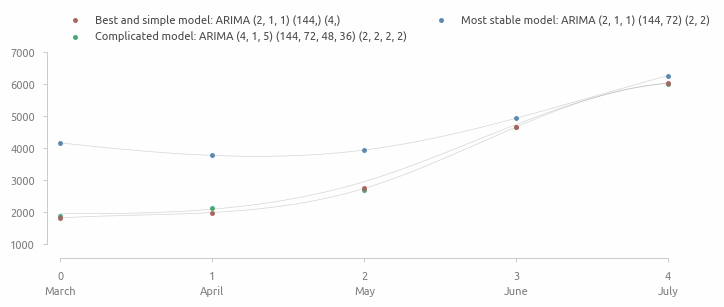

In [78]:
plt.plot(
    smoothed(cv1_results_df[cv1_results_best_model]),
    lw=0.5, color=palette[0], alpha=0.25)
plt.scatter(
    x=cv1_results_df.index,
    y=cv1_results_df[cv1_results_best_model],
    s=25, color=palette[1], zorder=10,
    label=f'Best and simple model: {cv1_results_best_model}',)

plt.plot(
    smoothed(cv1_results_df['ARIMA (4, 1, 5) (144, 72, 48, 36) (2, 2, 2, 2)']),
    lw=0.5, color=palette[0], alpha=0.25)
plt.scatter(
    x=cv1_results_df.index,
    y=cv1_results_df[cv1_results_second_best_model],
    s=25, color=saturate_color(palette[3], 1.5), zorder=9,
    label='Complicated model: ARIMA (4, 1, 5) (144, 72, 48, 36) (2, 2, 2, 2)')

plt.plot(
    smoothed(cv1_results_df['ARIMA (2, 1, 1) (144, 72) (2, 2)']),
    lw=0.5, color=palette[0], alpha=0.25)
plt.scatter(
    x=cv1_results_df.index,
    y=cv1_results_df['ARIMA (2, 1, 1) (144, 72) (2, 2)'],
    s=25, color=saturate_color(palette[2], 1.5), zorder=11,
    label=f'Most stable model: ARIMA (2, 1, 1) (144, 72) (2, 2)')

axis_rstyle(xticks=[0,4,1])
ax_sec = axis_secondary(ax=ax_current(), pad=30)
ax_sec.set_xticks(arange(5), months_list[2:7])

plt.legend(**legend_inline(2))

plt.show()

### Cross-validation 2: Fourier orders for best model

5-Fold CV:

- Model: ARIMA (2,1,1)(144)
- Orders: 2 to 8 (equal orders, without comvinations)

Explore the effect of larger Fourier order on best model

In [79]:
cv1_results_best_model

'ARIMA (2, 1, 1) (144,) (4,)'

In [80]:
cv1_results_best_model_order_str = \
    cv1_results_best_model[
        index_for_occurrence(cv1_results_best_model, '(', 1): \
        index_for_occurrence(cv1_results_best_model, ')', 1)+1
    ]

In [81]:
cv1_results_best_model_order = (
    int(cv1_results_best_model_order_str[1]), 
    int(cv1_results_best_model_order_str[4]), 
    int(cv1_results_best_model_order_str[7])
)

In [82]:
cv1_results_best_model_f_period_str = \
    cv1_results_best_model[
        index_for_occurrence(cv1_results_best_model, '(', 2)+1: \
        index_for_occurrence(cv1_results_best_model, ')', 2)
    ]

In [83]:
if cv1_results_best_model_f_period_str[-1] == ',':
    cv1_results_best_model_f_period = [int(cv1_results_best_model_f_period_str[:-1])]
else:
    cv1_results_best_model_f_period = \
        [int(i) for i in cv1_results_best_model_f_period_str.split(',')]

In [84]:
cv1_results_best_model_f_order_str = \
    cv1_results_best_model[
        index_for_occurrence(cv1_results_best_model, '(', 3)+1: \
        index_for_occurrence(cv1_results_best_model, ')', 3)
    ]

In [85]:
if cv1_results_best_model_f_order_str[-1] == ',':
    cv1_results_best_model_f_order = [int(cv1_results_best_model_f_order_str[:-1])]
else:
    cv1_results_best_model_f_order = \
        [int(i) for i in cv1_results_best_model_f_order_str.split(',')]

In [86]:
%%time

if len(cv1_results_best_model_f_order) == 1:
    
    cv1_results_best_model_f_order_fin = cv1_results_best_model_f_order[0] + 5
    cv2_fourier_orders = \
        arange(cv1_results_best_model_f_order[0], cv1_results_best_model_f_order_fin)

    cv2_results_dict = {}
    for fourier_order in cv2_fourier_orders:
        
        f_order = [fourier_order]
        model_name_1 = cv1_results_best_model_order
        model_name_2 = tuple(cv1_results_best_model_f_period)
        model_name_3 = tuple(f_order)
        model_name = f'ARIMA {model_name_1} ({model_name_2}) {model_name_3}'
        rmse2_list = []
        
        for idx_train, idx_eval in zip(cv_indexes_train, cv_indexes_eval):
    
            train_data = train.loc[idx_train, target]
            eval_data = train.loc[idx_eval, target]

            train_w_exogs, eval_w_exogs = \
                datasets_w_fourier(
                    fourier_period=f_period,
                    fourier_order=f_order,
                    train_data=train_data,
                    eval_data=eval_data,
                    train_exog=train.loc[idx_train, features],
                    eval_exog=train.loc[idx_eval, features])            
    
            rmse2_local = cv_arima_evaluation(
                data_train=train_data,
                data_eval=eval_data,
                order=cv1_results_best_model_order,
                exog_train=train_w_exogs,
                exog_eval=eval_w_exogs,
                metric=root_mean_squared_error,
                exec_time=False,
                clear_output_include=False)
            
            rmse2_list.append(rmse2_local)
    
        cv2_results_dict[model_name] = rmse2_list
        print(f'Evaluation of model {model_name} is finished')
    
    clear_output()

CPU times: user 11min 36s, sys: 2min 8s, total: 13min 44s
Wall time: 4min 53s


In [87]:
cv2_results_df = pd.DataFrame(cv2_results_dict)

In [88]:
cv2_results_df

,"ARIMA (2, 1, 1) ((144,)) (4,)","ARIMA (2, 1, 1) ((144,)) (5,)","ARIMA (2, 1, 1) ((144,)) (6,)","ARIMA (2, 1, 1) ((144,)) (7,)","ARIMA (2, 1, 1) ((144,)) (8,)"
0,1826.037357,1797.371590,1876.925024,1844.795731,1900.428397
1,1992.133181,2138.149095,2163.436139,2270.809231,2207.034016
2,2742.756733,2834.565329,3023.323730,3006.584011,2825.232366
3,4658.809261,4646.086744,4685.676447,4686.697705,4723.435547
4,6019.664304,5969.214151,6026.828291,6649.764510,6703.785799


In [89]:
cv2_results_df.mean().sort_values()

ARIMA (2, 1, 1) ((144,)) (4,)    3447.880167
ARIMA (2, 1, 1) ((144,)) (5,)    3477.077382
ARIMA (2, 1, 1) ((144,)) (6,)    3555.237926
ARIMA (2, 1, 1) ((144,)) (8,)    3671.983225
ARIMA (2, 1, 1) ((144,)) (7,)    3691.730237
dtype: float64

### Cross-validation 3: Fourier period increase and orders research

5-Fold CV:

- Model: ARIMA (2,1,1)
- Fourier periods: [144], [144, 72], [144, 72, 48],
- Orders: 4 to 6 (all conbinations)

Explore the effect of combinations Fourier order on best model

In [90]:
model_orders = [(2,1,1)]

In [91]:
fourier_periods = [[1008, 144], [144, 72], [144, 72, 48]]

In [92]:
fourier_orders = arange(4,6,True)

In [93]:
%%time

cv3_results_dict = {}
for order in model_orders:
    for f_period in fourier_periods:
        for f_order in itertools.product(fourier_orders, repeat=len(f_period)):
            
            model_name = f'ARIMA {order} {tuple(f_period)} {tuple(f_order)}'
            rmse3_list = []
            
            for idx_train, idx_eval in zip(cv_indexes_train, cv_indexes_eval):

                train_data = train.loc[idx_train, target]
                eval_data = train.loc[idx_eval, target]

                train_w_exogs, eval_w_exogs = \
                    datasets_w_fourier(
                        fourier_period=f_period,
                        fourier_order=f_order,
                        train_data=train_data,
                        eval_data=eval_data,
                        train_exog=train.loc[idx_train, features],
                        eval_exog=train.loc[idx_eval, features])

                rmse3_local = cv_arima_evaluation(
                    data_train=train_data,
                    data_eval=eval_data,
                    order=order,
                    exog_train=train_w_exogs,
                    exog_eval=eval_w_exogs,
                    metric=root_mean_squared_error,
                    exec_time=False,
                    clear_output_include=False)

                rmse3_list.append(rmse3_local)

            cv3_results_dict[model_name] = rmse3_list
            print(f'Evaluation of model {model_name} is finished')

clear_output()

CPU times: user 3h 5min 39s, sys: 37min 26s, total: 3h 43min 5s
Wall time: 1h 31min 53s


In [94]:
cv3_results_df = pd.DataFrame(cv3_results_dict)

In [95]:
cv3_results_df

,"ARIMA (2, 1, 1) (1008, 144) (4, 4)","ARIMA (2, 1, 1) (1008, 144) (4, 5)","ARIMA (2, 1, 1) (1008, 144) (4, 6)","ARIMA (2, 1, 1) (1008, 144) (5, 4)","ARIMA (2, 1, 1) (1008, 144) (5, 5)","ARIMA (2, 1, 1) (1008, 144) (5, 6)","ARIMA (2, 1, 1) (1008, 144) (6, 4)","ARIMA (2, 1, 1) (1008, 144) (6, 5)","ARIMA (2, 1, 1) (1008, 144) (6, 6)","ARIMA (2, 1, 1) (144, 72) (4, 4)",...,"ARIMA (2, 1, 1) (144, 72, 48) (5, 6, 6)","ARIMA (2, 1, 1) (144, 72, 48) (6, 4, 4)","ARIMA (2, 1, 1) (144, 72, 48) (6, 4, 5)","ARIMA (2, 1, 1) (144, 72, 48) (6, 4, 6)","ARIMA (2, 1, 1) (144, 72, 48) (6, 5, 4)","ARIMA (2, 1, 1) (144, 72, 48) (6, 5, 5)","ARIMA (2, 1, 1) (144, 72, 48) (6, 5, 6)","ARIMA (2, 1, 1) (144, 72, 48) (6, 6, 4)","ARIMA (2, 1, 1) (144, 72, 48) (6, 6, 5)","ARIMA (2, 1, 1) (144, 72, 48) (6, 6, 6)"
0,1707.511064,1634.158443,1692.720580,1709.539556,1636.617030,1694.989842,1679.991519,1606.154245,1665.363437,1924.621139,...,1943.769639,1959.543144,1944.128532,1944.537130,1953.679243,1942.332666,1943.773598,1953.674434,1942.344760,1943.762456
1,2286.983668,2318.131224,2309.555608,2263.757581,2297.933712,2289.249930,2292.553708,2322.851946,2317.727291,1988.731085,...,2028.176448,2127.920450,2150.331435,2125.990721,2118.096154,2131.384118,2028.171598,2118.038669,2131.383953,2028.170644
2,2956.535806,2913.719209,2891.027503,3001.392163,2987.874653,3023.112746,3016.676153,3031.824272,3116.844873,2726.233169,...,2862.440210,2775.469905,2793.890213,2777.182679,2863.478528,2882.082876,2862.440192,2863.478550,2882.082890,2862.440204
3,4765.667458,4756.003964,4788.094586,4768.644431,4758.702092,4791.153463,4804.689742,4795.344419,4825.544105,4734.542189,...,4766.830793,4748.442050,4752.594285,4766.035037,4748.413884,4752.713572,4766.829366,4748.446884,4752.715050,4766.263187
4,6689.644904,6606.985568,6649.971686,6722.525317,6635.824385,6682.174425,6975.156441,6895.903175,6965.446548,6052.972046,...,5958.492946,5987.961256,5977.089713,5937.686471,6003.748340,5995.005554,5958.493666,6003.723267,5995.004782,5958.493072


In [96]:
cv3_results_mean = cv3_results_df.mean(axis=0)

In [126]:
cv3_results_mean.sort_values()[:30]

ARIMA (2, 1, 1) (144, 72, 48) (4, 4, 6)    3473.017881
ARIMA (2, 1, 1) (144, 72, 48) (4, 4, 4)    3477.489196
ARIMA (2, 1, 1) (144, 72, 48) (4, 4, 5)    3479.731808
ARIMA (2, 1, 1) (144, 72) (4, 4)           3485.419926
ARIMA (2, 1, 1) (144, 72, 48) (4, 6, 4)    3506.057861
ARIMA (2, 1, 1) (144, 72, 48) (4, 5, 4)    3506.062576
ARIMA (2, 1, 1) (144, 72, 48) (4, 6, 5)    3508.074354
ARIMA (2, 1, 1) (144, 72, 48) (4, 5, 5)    3508.168321
ARIMA (2, 1, 1) (144, 72, 48) (5, 4, 6)    3510.281658
ARIMA (2, 1, 1) (144, 72, 48) (6, 4, 6)    3510.286408
ARIMA (2, 1, 1) (144, 72) (4, 5)           3511.572316
ARIMA (2, 1, 1) (144, 72, 48) (6, 6, 6)    3511.825913
ARIMA (2, 1, 1) (144, 72, 48) (5, 5, 6)    3511.865213
ARIMA (2, 1, 1) (144, 72, 48) (6, 5, 6)    3511.941684
ARIMA (2, 1, 1) (144, 72, 48) (5, 6, 6)    3511.942007
ARIMA (2, 1, 1) (144, 72) (4, 6)           3518.692583
ARIMA (2, 1, 1) (144, 72, 48) (6, 4, 4)    3519.867361
ARIMA (2, 1, 1) (144, 72, 48) (5, 4, 4)    3519.871087
ARIMA (2, 

In [98]:
train_by_week = train.loc['2017-02-01':].groupby(['month','week'])['target1'].mean().copy()

In [99]:
train_by_week = pd.DataFrame(train_by_week)

In [100]:
train_by_week['xticks'] = arange(len(train_by_week))

In [101]:
train_by_week.head(10)

target1  xticks
month week                      
2     5     30583.559322       0
      6     30620.320823       1
      7     31062.869249       2
      8     31481.355932       3
      9     31265.741525       4
3     9     30746.800000       5
      10    31181.975684       6
      11    31431.003040       7
      12    30691.173252       8
      13    31789.412766       9

In [102]:
months_list

['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']

In [103]:
cv1_results_df[cv1_results_best_model]

0    1826.037357
1    1992.133181
2    2742.756733
3    4658.809261
4    6019.664304
Name: ARIMA (2, 1, 1) (144,) (4,), dtype: float64

In [104]:
cv1_results_best_model_pct_change = \
    (cv1_results_df[cv1_results_best_model]
     / (cv1_results_df[cv1_results_best_model].iat[0] - 1) * 100)

In [105]:
cv1_results_best_model_pct_change

0    100.054793
1    109.155748
2    150.284964
3    255.271994
4    329.837868
Name: ARIMA (2, 1, 1) (144,) (4,), dtype: float64

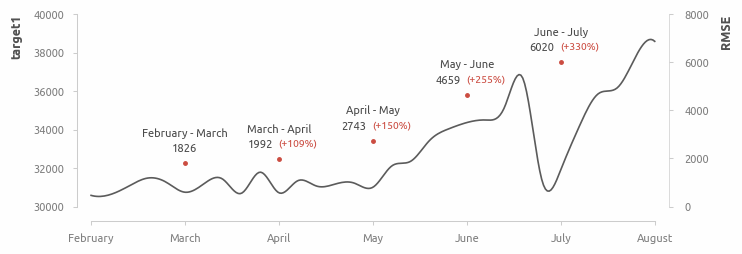

Images 'cv_rmse_plot.png' and 'cv_rmse_plot.svg' successfully saved into 'docs/img/' directory


In [472]:
fig, ax1 = plt.subplots()

# ax1.plot(train_by_week['xticks'], train_by_week['target1'])
ax1.plot(smoothed(train_by_week['target1'].values))
ax1.set_xticks([0, 5, 10, 15, 20 , 25, 30], months_list[1:8])
ax1.set_ylabel('target1')
axis_rstyle(offset_left=-10, ax=ax1)

ax2 = ax1.twinx()
ax2.scatter(
    x=[5, 10, 15, 20 , 25],
    y=cv1_results_df[cv1_results_best_model],
    color=saturate_color(palette[1], 1.5),
    s=25
)
months_rmse_names = [
    'February - March', 'March - April', 'April - May', 'May - June', 'June - July'
]
for i, j, k, v in zip(
    [5, 10, 15, 20 , 25],
    cv1_results_df[cv1_results_best_model],
    months_rmse_names,
    cv1_results_best_model_pct_change.index):
        if v > 0:
            delta_v = \
                cv1_results_best_model_pct_change.values[v]
            value_text = f'{int(round(j, 0))}'
            value_delta_text = f'(+{round(delta_v)}%)'
            
            ax2.text(s=value_text, x=i-1, y=j+450,
                 size=8, ha='center', color='#4B4B4B')
            ax2.text(s=value_delta_text, x=i+1, y=j+475,
                 size=7.5, ha='center', color=saturate_color(palette[1], 1.5))
        else:
            value_text = f'{int(round(j, 0))}'
            ax2.text(s=value_text, x=i, y=j+450,
                 size=8, ha='center', color='#4B4B4B')
            
        ax2.annotate(text=k, xy=(i, j+1100),
                     size=8, ha='center')

ax2.set_ylim(0, 8000)
ax2.grid(False)
ax2.spines['right'].set_visible(True)
ax2.spines['right'].set_color('#CCCCCC')
ax2.spines[['left', 'bottom']].set_visible(False)
ax2.tick_params(axis='y', direction='out', color='#CCCCCC', size=3)
ax2.tick_params(labelcolor='#808080')
# ax2.spines['right'].set_bounds(0, 0.25)
ax2.spines['right'].set_position(('outward', -10))
ax2.set_yticks(arange(0, 8001, 2000))
ax2.set_ylabel('RMSE')

plt.show()

savefig('cv_rmse_plot', dir_save_img)

## Validation Forecast : Base Model

In [144]:
cv1_results_best_model

'ARIMA (2, 1, 1) (144,) (4,)'

In [145]:
order = cv1_results_best_model_order
fourier_period = cv1_results_best_model_f_period
fourier_order = cv1_results_best_model_f_order

In [146]:
print(order, fourier_period, fourier_order)

(2, 1, 1) [144] [4]


#### August forecast

In [404]:
train_data = train.loc['2017-07', target]
valid_data = valid.loc[:, target]

train_features = train.loc['2017-07', features]
valid_features = valid.loc[:, features]

In [405]:
train_exogs, valid_exogs = \
    datasets_w_fourier(
        fourier_period=fourier_period,
        fourier_order=fourier_order,
        train_data=train_data,
        eval_data=valid_data,
        train_exog=train_features,
        eval_exog=valid_features)

In [406]:
train_data

2017-07-01 00:00:00    36384.31894
2017-07-01 00:10:00    35689.03654
2017-07-01 00:20:00    34751.36213
2017-07-01 00:30:00    33954.01993
2017-07-01 00:40:00    33411.82724
                          ...     
2017-07-31 23:10:00    43407.30897
2017-07-31 23:20:00    42507.90698
2017-07-31 23:30:00    41659.53488
2017-07-31 23:40:00    40843.05648
2017-07-31 23:50:00    39631.09635
Freq: 10min, Name: target1, Length: 4464, dtype: float64

In [407]:
train_exogs.head()

,"sin(1,144)","cos(1,144)","sin(2,144)","cos(2,144)","sin(3,144)","cos(3,144)","sin(4,144)","cos(4,144)",is_Friday,is_Sunday,is_31,target1_previous_month
2017-07-01 00:00:00,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0,0,0,38145.69536
2017-07-01 00:10:00,0.043619,0.999048,0.087156,0.996195,0.130526,0.991445,0.173648,0.984808,0,0,0,37827.81457
2017-07-01 00:20:00,0.087156,0.996195,0.173648,0.984808,0.258819,0.965926,0.342020,0.939693,0,0,0,36200.26490
2017-07-01 00:30:00,0.130526,0.991445,0.258819,0.965926,0.382683,0.923880,0.500000,0.866025,0,0,0,34966.88742
2017-07-01 00:40:00,0.173648,0.984808,0.342020,0.939693,0.500000,0.866025,0.642788,0.766044,0,0,0,34699.86755


In [408]:
valid_data

2017-08-01 00:00:00    38517.20311
2017-08-01 00:10:00    37973.80688
2017-08-01 00:20:00    37308.94562
2017-08-01 00:30:00    36164.61709
2017-08-01 00:40:00    35678.75694
                          ...     
2017-08-31 23:10:00    38619.48946
2017-08-31 23:20:00    38370.16648
2017-08-31 23:30:00    37724.48391
2017-08-31 23:40:00    36874.22863
2017-08-31 23:50:00    36215.76027
Freq: 10min, Name: target1, Length: 4464, dtype: float64

In [409]:
valid_exogs.head()

,"sin(1,144)","cos(1,144)","sin(2,144)","cos(2,144)","sin(3,144)","cos(3,144)","sin(4,144)","cos(4,144)",is_Friday,is_Sunday,is_31,target1_previous_month
2017-08-01 00:00:00,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0,0,0,36384.31894
2017-08-01 00:10:00,0.043619,0.999048,0.087156,0.996195,0.130526,0.991445,0.173648,0.984808,0,0,0,35689.03654
2017-08-01 00:20:00,0.087156,0.996195,0.173648,0.984808,0.258819,0.965926,0.342020,0.939693,0,0,0,34751.36213
2017-08-01 00:30:00,0.130526,0.991445,0.258819,0.965926,0.382683,0.923880,0.500000,0.866025,0,0,0,33954.01993
2017-08-01 00:40:00,0.173648,0.984808,0.342020,0.939693,0.500000,0.866025,0.642788,0.766044,0,0,0,33411.82724


In [410]:
model = SARIMAX(
    endog=train_data,
    exog=train_exogs,
    order=order,
    seasonal_order=(0, 0, 0, 0),
).fit(maxiter=1000, disp=False)

In [411]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                target1   No. Observations:                 4464
Model:               SARIMAX(2, 1, 1)   Log Likelihood              -33231.198
Date:                Sun, 21 Apr 2024   AIC                          66494.395
Time:                        21:25:43   BIC                          66596.853
Sample:                    07-01-2017   HQIC                         66530.512
                         - 07-31-2017                                         
Covariance Type:                  opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
sin(1,144)             -7549.9508    171.761    -43.956      0.000   -7886.597   -7213.305
cos(1,144)               682.5194    143.072      4.770      0.000     402.103     962.936
sin(

In [412]:
forecast = model.get_forecast(steps=len(valid_data), exog=valid_exogs)

In [413]:
y_pred = forecast.predicted_mean

In [414]:
y_true = valid_data

###### MAE

In [415]:
mean_absolute_error(y_true, y_pred)

1777.9319331656095

###### MAPE

In [416]:
mean_absolute_percentage_error(y_true, y_pred) * 100

5.142075774038464

###### RMSE

In [417]:
root_mean_squared_error(y_true, y_pred)

2306.996543858659

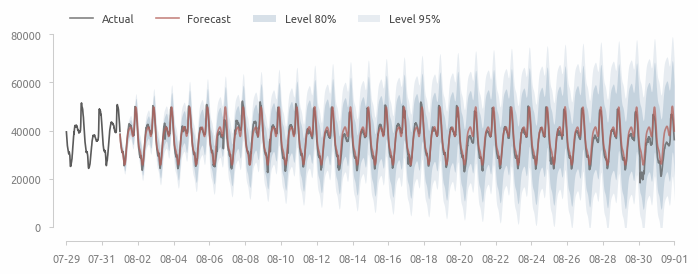

In [418]:
fig = plt.figure()
ax=ax_current()

plt.plot(train.loc['2017-07-29':, target], color=palette[0])

plot_forecast(
    y_true, y_pred, forecast, ci=[80, 95],
    palette=[palette[0], palette[1], palette[2]])

ax.set_xticks(
    ticks=pd.date_range(start='2017-07-29', end='2017-09-01', freq='2d'))
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%m-%d'))
axis_rstyle(ylim=[0, 80000])

### Residuals research

In [352]:
resid =  y_pred - y_true

In [353]:
test_normality(resid)

,Test,P or Statistic (s),Condition
0,Kolmogorov-Smirnov,0.0000,Not normal
1,Anderson-Darling (s),12.4603,Not normal
2,Shapiro-Wilk,0.0000,Not normal
3,Jarque-Bera,0.0000,Not normal
4,D’Agostino-Pearson,0.0000,Not normal


In [354]:
np.std(resid)

2110.602768310476

In [355]:
len(resid)

4464

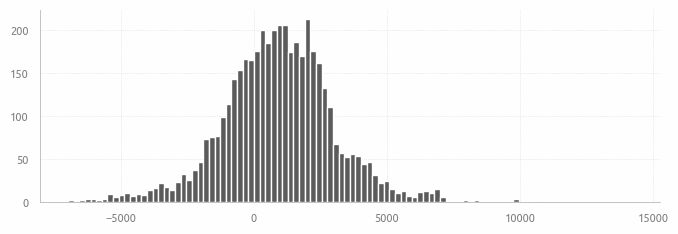

In [356]:
plt.hist(resid, bins=100);

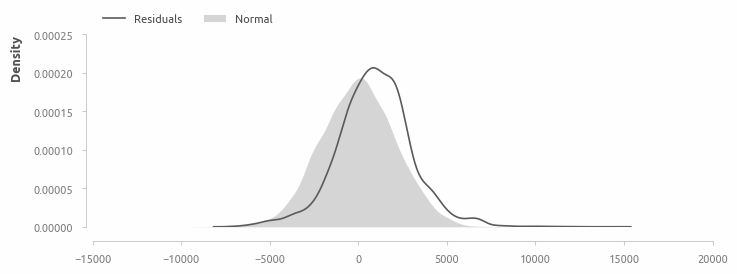

Images 'residuals_distribution_plot.png' and 'residuals_distribution_plot.svg' successfully saved into 'docs/img/' directory


In [358]:
fig = plt.figure()

sns.kdeplot(resid, color=palette[0], label='Residuals');
sns.kdeplot(
    np.random.normal(0, np.std(resid), len(resid)),
    color=palette[0], fill=True, lw=0.01, label='Normal');
axis_rstyle()

plt.legend(**legend_inline())
plt.show()

savefig('residuals_distribution_plot', dir_save_img)

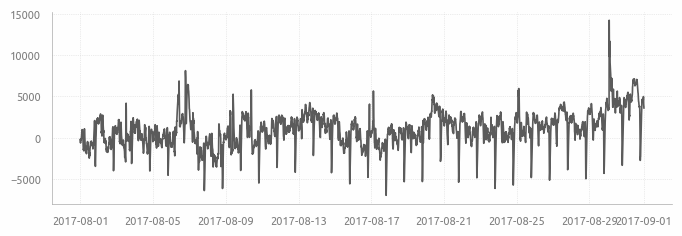

In [359]:
plt.plot(resid);

In [360]:
resid_mean = resid.groupby(resid.index.floor('D')).mean()

In [361]:
resid_mean.sort_values()

2017-08-08   -1396.073269
2017-08-07    -821.848626
2017-08-17    -645.889691
2017-08-01    -343.342107
2017-08-05    -222.296220
2017-08-16    -104.525043
2017-08-15      63.521006
2017-08-03     120.443398
2017-08-18     133.655247
2017-08-04     137.163603
2017-08-02     155.437434
2017-08-19     195.344230
2017-08-09     203.771369
2017-08-10     445.615865
2017-08-24     637.725092
2017-08-23     679.209670
2017-08-11     736.526276
2017-08-22     783.173348
2017-08-26    1116.048881
2017-08-28    1162.526354
2017-08-12    1191.240829
2017-08-21    1303.513499
2017-08-25    1341.269253
2017-08-14    1471.690886
2017-08-29    2077.279127
2017-08-27    2222.351487
2017-08-06    2292.053076
2017-08-13    2346.907782
2017-08-20    2597.293127
2017-08-30    4378.170711
2017-08-31    4616.825423
dtype: float64

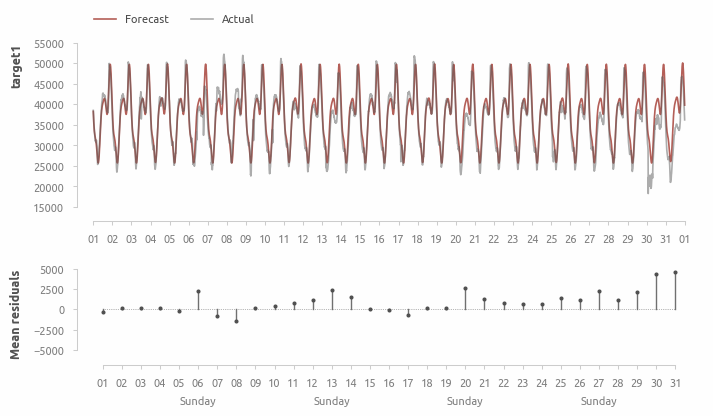

Images 'forecast_august_resid_mean_plot.png' and 'forecast_august_resid_mean_plot.svg' successfully saved into 'docs/img/' directory


In [362]:
fig, ax = plt.subplots(2, 1, figsize=(8, 4), height_ratios=[2, 1])

ax[0].plot(y_pred.index, y_pred, color=palette[1], label='Forecast')
ax[0].plot(y_true.index, y_true, color=palette[0], alpha=0.5, label='Actual')

ax[0].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%d'))
ax[0].xaxis.set_major_locator(mpl.dates.DayLocator())

ax[0].set_xlim(y_pred.index[0]-dt.timedelta(days=0.5), y_pred.index[-1]+dt.timedelta(days=1))
ax[0].set_ylabel('target1')
axis_rstyle(ax=ax[0])
ax[0].legend(**legend_inline(bbox_to_anchor=(0, 1.05)))

for i in resid_mean.index:
    ax[1].plot([i, i], [0, resid_mean[i]], color=palette[-3], lw=1)
    ax[1].scatter(i, resid_mean[i], s=15, color=palette[-4], zorder=10)

ax[1].plot(
    [resid_mean.index[0], resid_mean.index[-1]],
    [0, 0],
    lw=0.5, ls=':', color=palette[-3])

ax[1].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%d'))
ax[1].xaxis.set_major_locator(mpl.dates.DayLocator())
ax1_axis_sec =  ax[1].secondary_xaxis('bottom')
ax1_axis_sec.spines['bottom'].set_visible(False)
ax1_axis_sec.tick_params(pad=32, bottom=False, colors='#808080')
ax1_axis_sec.xaxis.set_major_locator(mpl.dates.WeekdayLocator(mpl.dates.SU))
ax1_axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%A'))

ax[1].set_xlim(y_pred.index[0]-dt.timedelta(days=1), y_pred.index[-1]+dt.timedelta(days=0.5))
ax[1].set_ylabel('Mean residuals')

axis_rstyle(xslice=[1, -1], yticks=[-5000, 5000, 2500], ylim=[-5100, 5000], ax=ax[1])

plt.subplots_adjust(hspace=0.5)
plt.show()

savefig('forecast_august_resid_mean_plot', dir_save_img)

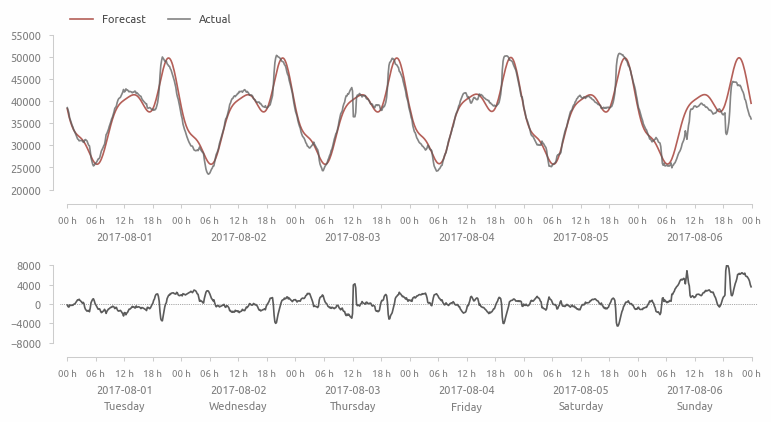

Images 'forecast_august_detail_plot_week1.png' and 'forecast_august_detail_plot_week1.svg' successfully saved into 'docs/img/' directory


In [363]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4), height_ratios=[2, 1])

ax[0].plot(
    y_pred.loc['2017-08-01':'2017-08-06'],
    color=palette[1], label='Forecast')
ax[0].plot(
    y_true.loc['2017-08-01':'2017-08-06'],
    color=palette[0], alpha=0.75, label='Actual')

ax[0].legend(**legend_inline())
ax[0].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[0].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[0].tick_params(axis='x', which='minor', labelsize=7)
ax[0].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec = ax[0].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(ax=ax[0], xslice=[1, -1])


ax[1].plot(resid.loc['2017-08-01':'2017-08-06'])
ax[1].axhline(0, lw=0.5, ls=':')

ax[1].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[1].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[1].tick_params(axis='x', which='minor', labelsize=7)
ax[1].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec =  ax[1].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_th = axis_secondary(ax=ax[1], pad=42)
axis_th.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%A'))
axis_th.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(xslice=[1, -1], yticks=[-8000, 8000, 4000], ylim=[-8000, 8000], ax=ax[1])

plt.subplots_adjust(hspace=0.65)
plt.show()

savefig('forecast_august_detail_plot_week1', dir_save_img)

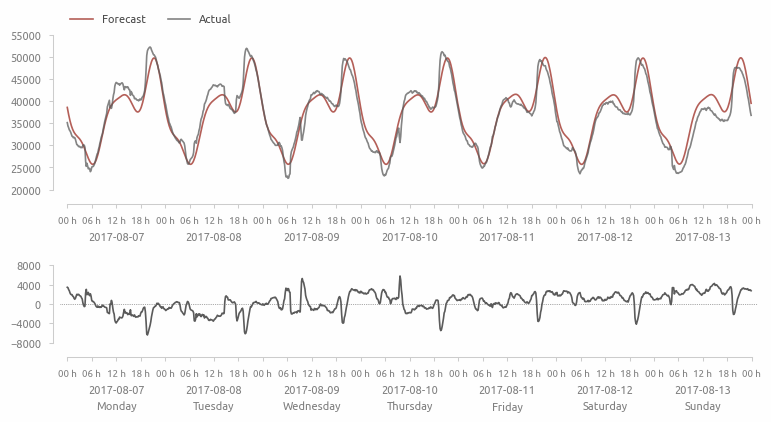

Images 'forecast_august_detail_plot_week2.png' and 'forecast_august_detail_plot_week2.svg' successfully saved into 'docs/img/' directory


In [364]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4), height_ratios=[2, 1])

ax[0].plot(
    y_pred.loc['2017-08-07':'2017-08-13'],
    color=palette[1], label='Forecast')
ax[0].plot(
    y_true.loc['2017-08-07':'2017-08-13'],
    color=palette[0], alpha=0.75, label='Actual')

ax[0].legend(**legend_inline())
ax[0].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[0].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[0].tick_params(axis='x', which='minor', labelsize=7)
ax[0].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec = ax[0].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(ax=ax[0], xslice=[1, -1])


ax[1].plot(resid.loc['2017-08-07':'2017-08-13'])
ax[1].axhline(0, lw=0.5, ls=':')

ax[1].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[1].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[1].tick_params(axis='x', which='minor', labelsize=7)
ax[1].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec =  ax[1].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_th = axis_secondary(ax=ax[1], pad=42)
axis_th.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%A'))
axis_th.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(xslice=[1, -1], yticks=[-8000, 8000, 4000], ylim=[-8000, 8000], ax=ax[1])

plt.subplots_adjust(hspace=0.65)
plt.show()

savefig('forecast_august_detail_plot_week2', dir_save_img)

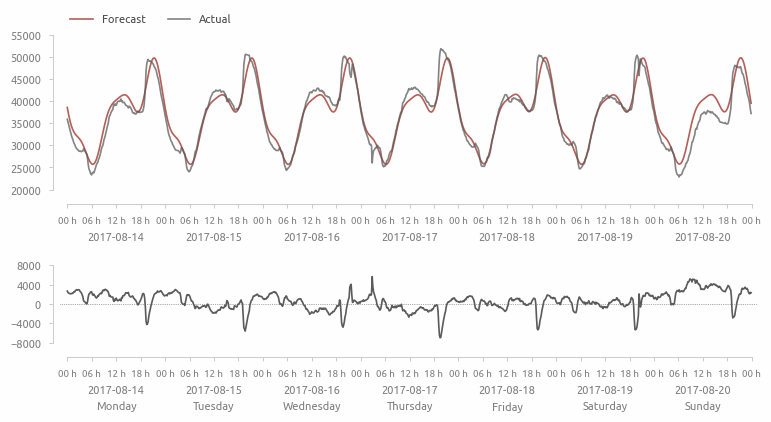

Images 'forecast_august_detail_plot_week3.png' and 'forecast_august_detail_plot_week3.svg' successfully saved into 'docs/img/' directory


In [365]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4), height_ratios=[2, 1])

ax[0].plot(
    y_pred.loc['2017-08-14':'2017-08-20'],
    color=palette[1], label='Forecast')
ax[0].plot(
    y_true.loc['2017-08-14':'2017-08-20'],
    color=palette[0], alpha=0.75, label='Actual')

ax[0].legend(**legend_inline())
ax[0].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[0].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[0].tick_params(axis='x', which='minor', labelsize=7)
ax[0].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec = ax[0].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(ax=ax[0], xslice=[1, -1])


ax[1].plot(resid.loc['2017-08-14':'2017-08-20'])
ax[1].axhline(0, lw=0.5, ls=':')

ax[1].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[1].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[1].tick_params(axis='x', which='minor', labelsize=7)
ax[1].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec =  ax[1].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_th = axis_secondary(ax=ax[1], pad=42)
axis_th.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%A'))
axis_th.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(xslice=[1, -1], yticks=[-8000, 8000, 4000], ylim=[-8000, 8000], ax=ax[1])

plt.subplots_adjust(hspace=0.65)
plt.show()

savefig('forecast_august_detail_plot_week3', dir_save_img)

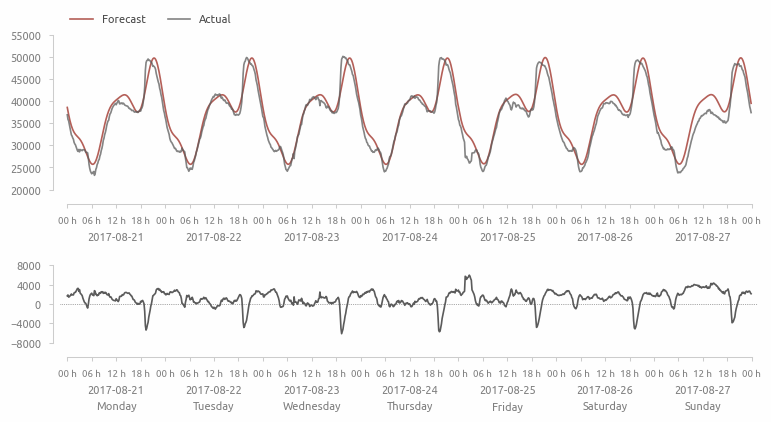

Images 'forecast_august_detail_plot_week4.png' and 'forecast_august_detail_plot_week4.svg' successfully saved into 'docs/img/' directory


In [366]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4), height_ratios=[2, 1])

ax[0].plot(
    y_pred.loc['2017-08-21':'2017-08-27'],
    color=palette[1], label='Forecast')
ax[0].plot(
    y_true.loc['2017-08-21':'2017-08-27'],
    color=palette[0], alpha=0.75, label='Actual')

ax[0].legend(**legend_inline())
ax[0].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[0].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[0].tick_params(axis='x', which='minor', labelsize=7)
ax[0].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec = ax[0].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(ax=ax[0], xslice=[1, -1])


ax[1].plot(resid.loc['2017-08-21':'2017-08-27'])
ax[1].axhline(0, lw=0.5, ls=':')

ax[1].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[1].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[1].tick_params(axis='x', which='minor', labelsize=7)
ax[1].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec =  ax[1].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_th = axis_secondary(ax=ax[1], pad=42)
axis_th.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%A'))
axis_th.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(xslice=[1, -1], yticks=[-8000, 8000, 4000], ylim=[-8000, 8000], ax=ax[1])

plt.subplots_adjust(hspace=0.65)
plt.show()

savefig('forecast_august_detail_plot_week4', dir_save_img)

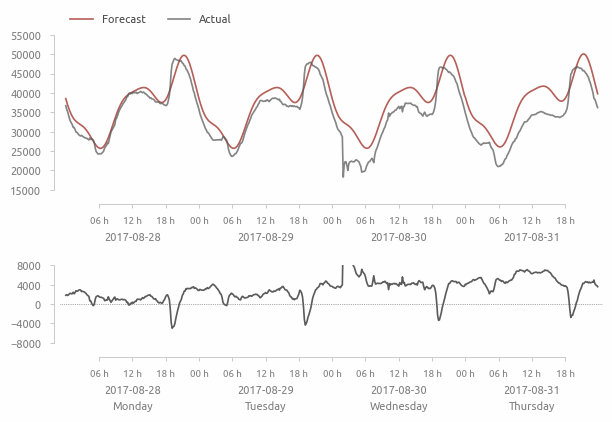

Images 'forecast_august_detail_plot_week5.png' and 'forecast_august_detail_plot_week5.svg' successfully saved into 'docs/img/' directory


In [367]:
fig, ax = plt.subplots(2, 1, figsize=(7, 4), height_ratios=[2, 1])

ax[0].plot(
    y_pred.loc['2017-08-28':'2017-08-31'],
    color=palette[1], label='Forecast')
ax[0].plot(
    y_true.loc['2017-08-28':'2017-08-31'],
    color=palette[0], alpha=0.75, label='Actual')

ax[0].legend(**legend_inline())
ax[0].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[0].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[0].tick_params(axis='x', which='minor', labelsize=7)
ax[0].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec = ax[0].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(ax=ax[0], xslice=[1, -1])


ax[1].plot(resid.loc['2017-08-28':'2017-08-31'])
ax[1].axhline(0, lw=0.5, ls=':')

ax[1].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[1].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[1].tick_params(axis='x', which='minor', labelsize=7)
ax[1].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec =  ax[1].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_th = axis_secondary(ax=ax[1], pad=42)
axis_th.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%A'))
axis_th.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(xslice=[1, -1], yticks=[-8000, 8000, 4000], ylim=[-8000, 8000], ax=ax[1])

plt.subplots_adjust(hspace=0.65)
plt.show()

savefig('forecast_august_detail_plot_week5', dir_save_img)

## Boosting Strategies

Predict sepaartely:
- Predict: Residuals
- Predict: First Residual and then Residuals Diff (and after that predict all residuals series)
- Predict: Residuals rolling window

Crate ensemble of boosters.

## Detailed CV Research

In [448]:
%%time
cv1_residuals = cv_residuals(
    data=train,
    target=target,
    features=features,
    cv_indexes_train=cv_indexes_train,
    cv_indexes_eval=cv_indexes_eval,
    model_order=(2,1,1),
    fourier_preiod=[144],
    fourier_order=[4]
)

CPU times: user 2min 22s, sys: 27.1 s, total: 2min 49s
Wall time: 1min 4s


In [449]:
cv1_residuals

,true,pred,resid,resid_diff
2017-03-01 00:00:00,29069.61702,29015.084071,-54.532949,NaN
2017-03-01 00:10:00,28579.40426,28388.965288,-190.438972,-135.906023
2017-03-01 00:20:00,27844.08511,27804.902932,-39.182178,151.256794
2017-03-01 00:30:00,27237.44681,27296.283427,58.836617,98.018795
2017-03-01 00:40:00,26882.04255,26808.874138,-73.168412,-132.005030
...,...,...,...,...
2017-07-31 23:10:00,43407.30897,39896.428460,-3510.880510,307.778997
2017-07-31 23:20:00,42507.90698,39579.899891,-2928.007089,582.873421
2017-07-31 23:30:00,41659.53488,39303.815983,-2355.718897,572.288192
2017-07-31 23:40:00,40843.05648,39030.714961,-1812.341519,543.377378


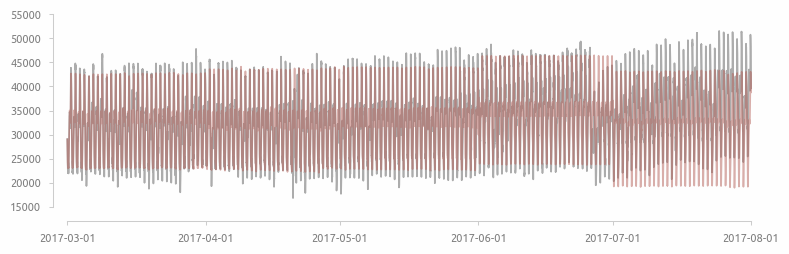

In [452]:
plt.figure(figsize=(9 ,2.5))
plt.plot(
    cv1_residuals.loc['2017-03-01':, 'true'], color=palette[0], alpha=0.5)
plt.plot(
    cv1_residuals.loc[:, 'pred'], color=palette[1], alpha=0.5)
axis_rstyle()

Images 'cv_results_close1.png' and 'cv_results_close1.svg' successfully saved into 'docs/img/' directory


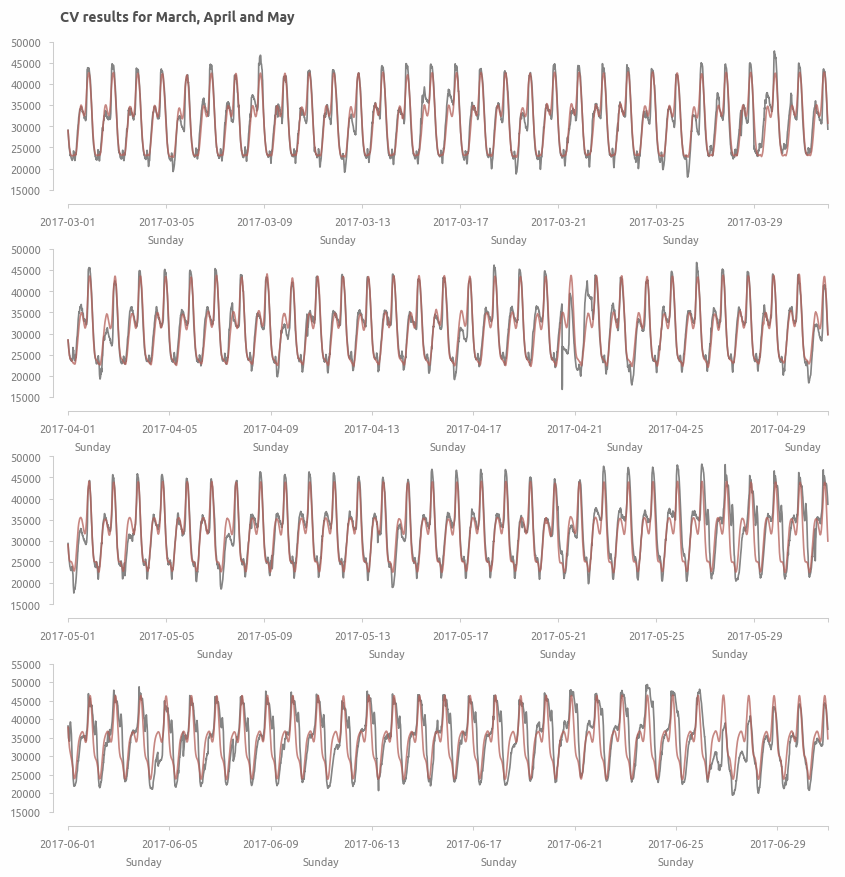

In [474]:
fig, ax = plt.subplots(4, 1, figsize=(10, 10))

ax[0].set_title('CV results for March, April and May')

ax[0].plot(
    cv1_residuals.loc['2017-03', 'true'], color=palette[0], alpha=0.75)
ax[0].plot(
    cv1_residuals.loc['2017-03', 'pred'], color=palette[1], alpha=0.75)
axis_rstyle(ax=ax[0])
ax0_sec = axis_secondary(ax=ax[0])
ax0_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%A'))
ax0_sec.xaxis.set_major_locator(mpl.dates.WeekdayLocator(byweekday=mpl.dates.SU))
ax[0].xaxis.get_major_ticks()[-1].label1.set_visible(False)

ax[1].plot(
    cv1_residuals.loc['2017-04', 'true'], color=palette[0], alpha=0.75)
ax[1].plot(
    cv1_residuals.loc['2017-04', 'pred'], color=palette[1], alpha=0.75)
axis_rstyle(ax=ax[1])
ax1_sec = axis_secondary(ax=ax[1])
ax1_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%A'))
ax1_sec.xaxis.set_major_locator(mpl.dates.WeekdayLocator(byweekday=mpl.dates.SU))
ax[1].xaxis.get_major_ticks()[-1].label1.set_visible(False)

ax[2].plot(
    cv1_residuals.loc['2017-05', 'true'], color=palette[0], alpha=0.75)
ax[2].plot(
    cv1_residuals.loc['2017-05', 'pred'], color=palette[1], alpha=0.75)
axis_rstyle(ax=ax[2])
ax2_sec = axis_secondary(ax=ax[2])
ax2_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%A'))
ax2_sec.xaxis.set_major_locator(mpl.dates.WeekdayLocator(byweekday=mpl.dates.SU))
ax[2].xaxis.get_major_ticks()[-1].label1.set_visible(False)

ax[3].plot(
    cv1_residuals.loc['2017-06', 'true'], color=palette[0], alpha=0.75)
ax[3].plot(
    cv1_residuals.loc['2017-06', 'pred'], color=palette[1], alpha=0.75)
axis_rstyle(ax=ax[3])
ax3_sec = axis_secondary(ax=ax[3])
ax3_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%A'))
ax3_sec.xaxis.set_major_locator(mpl.dates.WeekdayLocator(byweekday=mpl.dates.SU))
ax[3].xaxis.get_major_ticks()[-1].label1.set_visible(False)

plt.subplots_adjust(hspace=0.4)

savefig('cv_results_close1', dir_save_img)

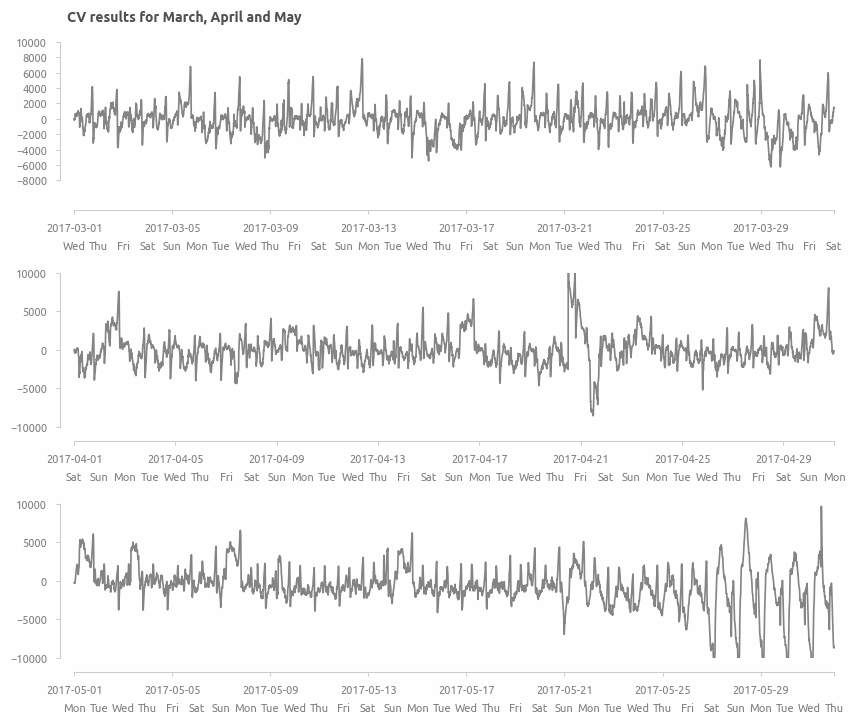

Images 'cv_results_close2.png' and 'cv_results_close2.svg' successfully saved into 'docs/img/' directory


In [455]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8))

ax[0].set_title('CV results for March, April and May')

ax[0].plot(
    cv1_residuals.loc['2017-03-01':'2017-03-31', 'resid'], color=palette[0], alpha=0.75)
axis_rstyle(ax=ax[0], ylim=[-10000, 10000, 2000])
ax0_sec = axis_secondary(ax=ax[0])
ax0_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%a'))
ax0_sec.xaxis.set_major_locator(mpl.dates.DayLocator())
ax[0].xaxis.get_major_ticks()[-1].label1.set_visible(False)

ax[1].plot(
    cv1_residuals.loc['2017-04-01':'2017-04-30', 'resid'], color=palette[0], alpha=0.75)
axis_rstyle(ax=ax[1], ylim=[-10000, 10000, 2000])
ax1_sec = axis_secondary(ax=ax[1])
ax1_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%a'))
ax1_sec.xaxis.set_major_locator(mpl.dates.DayLocator())
ax[1].xaxis.get_major_ticks()[-1].label1.set_visible(False)

ax[2].plot(
    cv1_residuals.loc['2017-05-01':'2017-05-31', 'resid'], color=palette[0], alpha=0.75)
axis_rstyle(ax=ax[2], ylim=[-10000, 10000, 2000])
ax2_sec = axis_secondary(ax=ax[2])
ax2_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%a'))
ax2_sec.xaxis.set_major_locator(mpl.dates.DayLocator())
ax[2].xaxis.get_major_ticks()[-1].label1.set_visible(False)

plt.subplots_adjust(hspace=0.5)
plt.show()

savefig('cv_results_close2', dir_save_img)

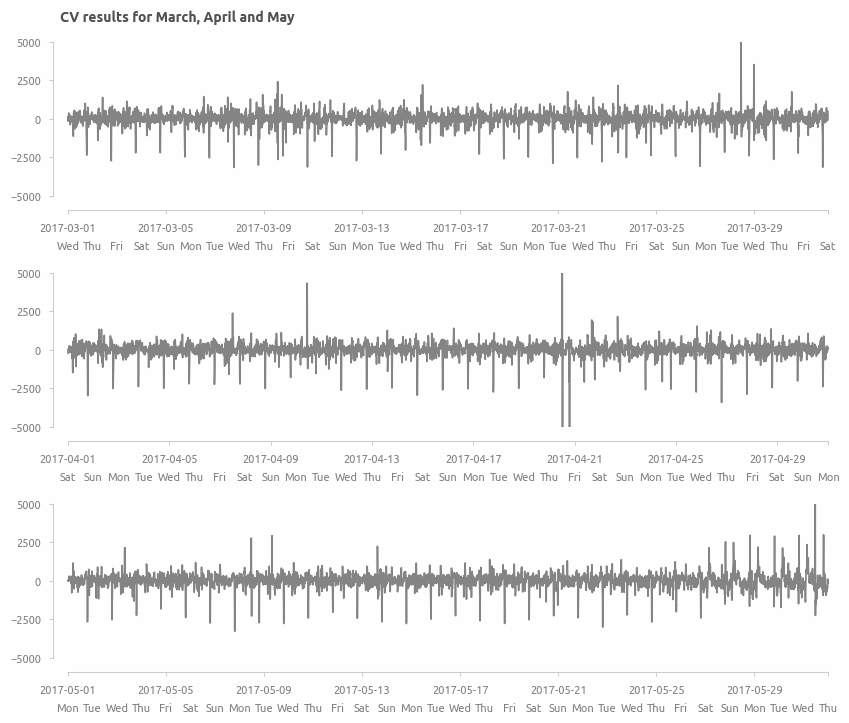

In [456]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8))

ax[0].set_title('CV results for March, April and May')

ax[0].plot(
    cv1_residuals.loc['2017-03-01':'2017-03-31', 'resid_diff'], color=palette[0], alpha=0.75)
axis_rstyle(ax=ax[0], yticks=[-5000, 5000, 2500], ylim=[-5000, 5000])
ax0_sec = axis_secondary(ax=ax[0])
ax0_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%a'))
ax0_sec.xaxis.set_major_locator(mpl.dates.DayLocator())
ax[0].xaxis.get_major_ticks()[-1].label1.set_visible(False)

ax[1].plot(
    cv1_residuals.loc['2017-04-01':'2017-04-30', 'resid_diff'], color=palette[0], alpha=0.75)
axis_rstyle(ax=ax[1], yticks=[-5000, 5000, 2500], ylim=[-5000, 5000])
ax1_sec = axis_secondary(ax=ax[1])
ax1_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%a'))
ax1_sec.xaxis.set_major_locator(mpl.dates.DayLocator())
ax[1].xaxis.get_major_ticks()[-1].label1.set_visible(False)

ax[2].plot(
    cv1_residuals.loc['2017-05-01':'2017-05-31', 'resid_diff'], color=palette[0], alpha=0.75)
axis_rstyle(ax=ax[2], yticks=[-5000, 5000, 2500], ylim=[-5000, 5000])
ax2_sec = axis_secondary(ax=ax[2])
ax2_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%a'))
ax2_sec.xaxis.set_major_locator(mpl.dates.DayLocator())
ax[2].xaxis.get_major_ticks()[-1].label1.set_visible(False)

plt.subplots_adjust(hspace=0.5)
plt.show()

# savefig('cv_results_close2', dir_save_img)

In [457]:
cv1_residuals.loc['2017-03-01':'2017-03-10', 'resid_diff'].rolling(2).sum()

2017-03-01 00:00:00           NaN
2017-03-01 00:10:00           NaN
2017-03-01 00:20:00     15.350771
2017-03-01 00:30:00    249.275589
2017-03-01 00:40:00    -33.986234
                          ...    
2017-03-10 23:10:00    223.738829
2017-03-10 23:20:00    160.728391
2017-03-10 23:30:00    466.116290
2017-03-10 23:40:00    336.298345
2017-03-10 23:50:00    -23.331108
Freq: 10min, Name: resid_diff, Length: 1440, dtype: float64

In [458]:
cv1_residuals.loc['2017-03-01':'2017-03-10', 'resid_diff']

2017-03-01 00:00:00           NaN
2017-03-01 00:10:00   -135.906023
2017-03-01 00:20:00    151.256794
2017-03-01 00:30:00     98.018795
2017-03-01 00:40:00   -132.005030
                          ...    
2017-03-10 23:10:00    -68.454009
2017-03-10 23:20:00    229.182400
2017-03-10 23:30:00    236.933890
2017-03-10 23:40:00     99.364454
2017-03-10 23:50:00   -122.695563
Freq: 10min, Name: resid_diff, Length: 1440, dtype: float64

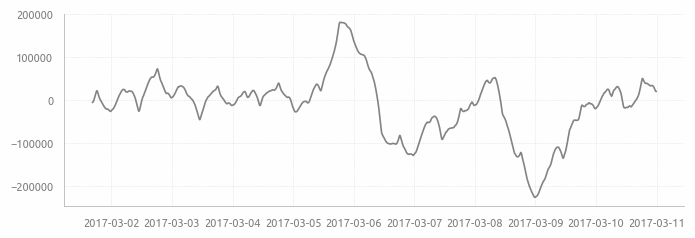

In [460]:
plt.plot(
    cv1_residuals.loc['2017-03-01':'2017-03-10', 'resid'].rolling(100).sum(), color=palette[0], alpha=0.75)

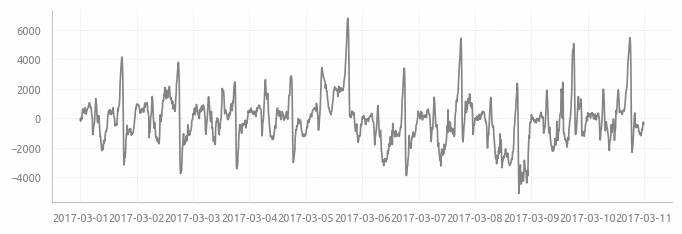

In [461]:
plt.plot(
    cv1_residuals.loc['2017-03-01':'2017-03-10', 'resid'], color=palette[0], alpha=0.75)

## Save Data

### Save Session

In [192]:
save_session(session_name)

### Execution time

In [193]:
print(f'Execution time: {stopwatch.stop(start)}')

Execution time: 0:06:07
